In [1]:
!pip install turicreate
!pip install kaggle 
!pip install gensim
!pip install pyLDAvis
!pip install spaCy
!pip install afinn
!pip install nltk
!pip install plotly_express

import nltk
nltk.download('stopwords')
nltk.download('punkt')

!python -m spacy download en_core_web_lg

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_lg')


In [9]:
import spacy
from tqdm import tqdm
from itertools import product
import networkx as nx
import matplotlib.pyplot as plt
from IPython.display import Image
import turicreate as tc
from afinn import Afinn
from turicreate import aggregate as agg

In [2]:
from google.colab import files
files.upload() #upload kaggle.json

!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

Saving kaggle.json to kaggle (1).json
kaggle.json


# Homework Assignment 7

**Question 1:** Select two books and construct networks of people and locations, i.e. each link is between a a person and a location (20pt). Visualize the network using Cytoscape or Gephi (20pt).


In [3]:
print("I'm a fan on LOTR so it's an easy choice for me")

I'm a fan on LOTR so it's an easy choice for me


In [4]:
!mkdir ./datasets
!mkdir ./datasets/lor

# download the dataset from Kaggle and unzip it
!kaggle datasets download ashishsinhaiitr/lord-of-the-rings-text -p ./datasets/lor
!unzip ./datasets/lor/*.zip  -d ./datasets/lor/

mkdir: cannot create directory ‘./datasets’: File exists
mkdir: cannot create directory ‘./datasets/lor’: File exists
lord-of-the-rings-text.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  ./datasets/lor/lord-of-the-rings-text.zip
replace ./datasets/lor/01 - The Fellowship Of The Ring.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [14]:
nlp = spacy.load('en_core_web_lg')
book1 = './datasets/lor/01 - The Fellowship Of The Ring.txt'
book2 = './datasets/lor/02 - The Two Towers.txt'

def get_entites_dict_from_text(text):
    entities_dict= {}
    #using spaCy to get entities
    doc = nlp(text)
    for entity in doc.ents:
        label = entity.label_
        e = entity.text.lower()
        if  label not in entities_dict:
            entities_dict[label] = {}
        if e not in entities_dict[label]:
            entities_dict[label][e] = 0
        entities_dict[label][e] += 1
    return entities_dict

def get_txt_entities(txt, times_dict):
    txt = txt.replace("\n", " ")
    doc = nlp(txt)
    d = get_entites_dict_from_text(txt) 
    entities_dict = {}

    for k in d.keys():
        min_times = times_dict.get(k)
        if not min_times:
            min_times = times_dict['DEFAULT']

        entity_dict = {k:v for k,v in d[k].items() if v>min_times}
        entities_dict[k] = entity_dict
    return entities_dict


TIMES_DICT = {
    'PERSON':1,
    'LOC':1,
    'DEFAULT':1
}

def get_txt_links(txt):
    links_set = set()
    txt_ents = get_txt_entities(txt, TIMES_DICT)
    # a link is added for each couple (LOCATION, PERSON) in the same
    # paragraph.
    persons = txt_ents.get('PERSON')
    locations = txt_ents.get('LOC')
    if persons and locations:
        for link in product(persons, locations):
            links_set.add(link)
    return links_set

def get_persons_links(book_path):
    txt = open(book_path,"r", encoding="utf8", errors="ignore").read()
    links_set = set()
    paragraphs_list = txt.split("\n\n")
    para = paragraphs_list[0]
    for para in tqdm(paragraphs_list):
        for link in get_txt_links(para):
            links_set.add(link)
    return links_set
    
p1 = get_persons_links(book1)
p2 = get_persons_links(book2)

100%|██████████| 297/297 [01:01<00:00,  4.83it/s]


In [17]:


g = nx.Graph()
g.add_edges_from(p1)
nx.write_gml(g, "./datasets/g.gml")

g2 = nx.Graph()
g2.add_edges_from(p2)
nx.write_gml(g2, "./datasets/g2.gml")

In [21]:
print("I did 2 things: 1. node size if a common place, but not only")
print("2. the color is from yellow (not common) to red (most common)")

I did 2 things: 1. node size if a common place, but not only
2. the color is from yellow (not common) to red (most common)


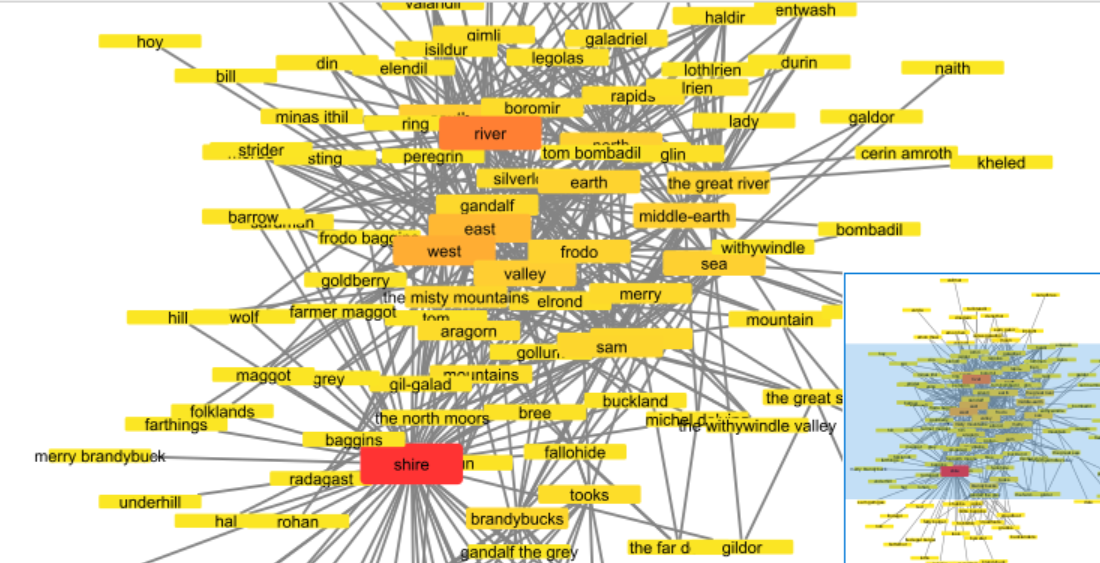

In [20]:
Image(filename='./datasets/book1.png')

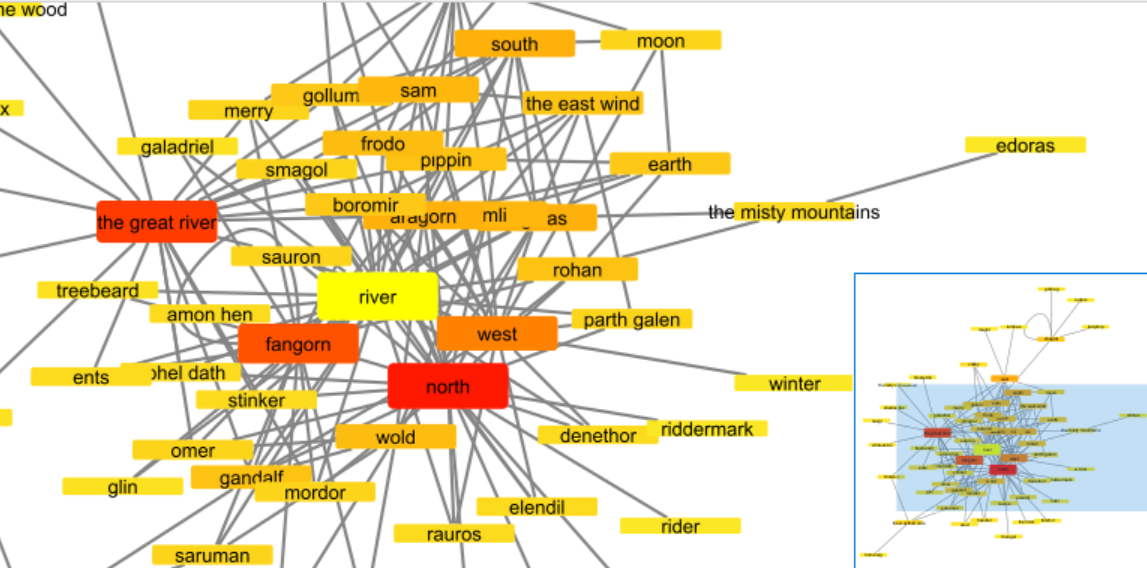

In [22]:
Image(filename='./datasets/book2.png')

**Question 2:** Use the [Friends TV Show Transcript](https://www.kaggle.com/ryanstonebraker/friends-transcript)
to create and evaluate a classifier that given a line of text can predict
 who is the "friend" that said it (20pt). Using sentiment analysis identify who are the most and less friendly friends (20pt). Construct a classifier that can be given several text lines (quotes) from a specific episode that will predict the episode's season number (20pt).

In [23]:
DATASET_NAME = 'friends'
KAGGLE_REPO = 'ryanstonebraker/friends-transcript'
!rm -r ./datasets/$DATASET_NAME/
!mkdir -p ./datasets/$DATASET_NAME/data
!mkdir -p ./datasets/$DATASET_NAME/zip
!mkdir -p ./datasets/$DATASET_NAME/sql

!kaggle datasets list -s $DATASET_NAME
# download the dataset from Kaggle and unzip it
!kaggle datasets download $KAGGLE_REPO -p ./datasets/$DATASET_NAME/zip
!unzip ./datasets/$DATASET_NAME/zip/*.zip -d ./datasets/$DATASET_NAME/data

rm: cannot remove './datasets/friends/': No such file or directory
ref                                                         title                                               size  lastUpdated          downloadCount  
----------------------------------------------------------  -------------------------------------------------  -----  -------------------  -------------  
rezaghari/friends-series-dataset                            Friends Series Dataset                              20KB  2020-04-26 04:54:19            417  
hwassner/TwitterFriends                                     Twitter Friends                                    175MB  2016-09-02 13:28:00           2320  
blessondensil294/friends-tv-series-screenplay-script        FRIENDS TV Series - Screenplay Script                2MB  2020-09-14 13:18:19             66  
divyansh22/friends-tv-show-script                           Friends TV Show Script                               2MB  2020-07-13 06:13:57             43  
mpw

In [5]:
sf = tc.SFrame.read_csv('./datasets/friends/data/friends_quotes.csv')

Finished parsing file /content/datasets/friends/data/friends_quotes.csv

Parsing completed. Parsed 100 lines in 0.272044 secs.

------------------------------------------------------
Inferred types from first 100 line(s) of file as 
column_type_hints=[str,float,str,str,float,float]
If parsing fails due to incorrect types, you can correct
the inferred type list above and pass it to read_csv in
the column_type_hints argument
------------------------------------------------------


Finished parsing file /content/datasets/friends/data/friends_quotes.csv

Parsing completed. Parsed 60291 lines in 0.167905 secs.

In [6]:
print("Last notebook, the 1 gram and 2 gram did a good job, so i did the same thing here")

Last notebook, the 1 gram and 2 gram did a good job, so i did the same thing here


In [7]:
sf['words_1grams'] = tc.text_analytics.count_ngrams(sf['quote'], n=1, method='word')
sf['words_2grams'] = tc.text_analytics.count_ngrams(sf['quote'], n=2, method='word')
main_actors = ["Monica", "Joey", "Phoebe", "Chandler", "Rachel", "Ross"]
sf = sf.filter_by(main_actors, 'author')
train, test = sf.random_split(0.8)
cls = tc.classifier.create(train,features=['words_1grams', 'words_2grams'], target="author")
cls.evaluate(test)

PROGRESS: Creating a validation set from 5 percent of training data. This may take a while.
          You can set ``validation_set=None`` to disable validation tracking.

PROGRESS: The following methods are available for this type of problem.
PROGRESS: BoostedTreesClassifier, RandomForestClassifier, DecisionTreeClassifier, LogisticClassifier
PROGRESS: The returned model will be chosen according to validation accuracy.


Boosted trees classifier:

--------------------------------------------------------

Number of examples          : 34505

Number of classes           : 6

Number of feature columns   : 2

Number of unpacked features : 130706

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| Iteration | Elapsed Time | Training Accuracy | Validation Accuracy | Training Log Loss | Validation Log Loss |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| 1         | 1.005250     | 0.245008          | 0.234452            | 1.769010          | 1.775562            |

| 2         | 2.033275     | 0.260455          | 0.248762            | 1.753101          | 1.765481            |

| 3         | 3.044316     | 0.267353          | 0.250413            | 1.740831          | 1.757848            |

| 4         | 4.077612     | 0.274018          | 0.251513            | 1.730016          | 1.753150            |

| 5         | 5.069076     | 0.278394          | 0.252614            | 1.721199          | 1.747687            |

| 10        | 9.931504     | 0.312013          | 0.256467            | 1.684049          | 1.728565            |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

Random forest classifier:

--------------------------------------------------------

Number of examples          : 34505

Number of classes           : 6

Number of feature columns   : 2

Number of unpacked features : 130706

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| Iteration | Elapsed Time | Training Accuracy | Validation Accuracy | Training Log Loss | Validation Log Loss |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| 1         | 0.850104     | 0.243037          | 0.237755            | 1.740634          | 1.760197            |

| 2         | 1.700598     | 0.251036          | 0.245460            | 1.735769          | 1.752213            |

| 3         | 2.500592     | 0.253847          | 0.247111            | 1.734655          | 1.751049            |

| 4         | 3.300386     | 0.253818          | 0.244909            | 1.734816          | 1.750203            |

| 5         | 4.150352     | 0.258310          | 0.245460            | 1.733819          | 1.750978            |

| 10        | 8.222099     | 0.262889          | 0.253165            | 1.732300          | 1.750126            |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

Decision tree classifier:

--------------------------------------------------------

Number of examples          : 34505

Number of classes           : 6

Number of feature columns   : 2

Number of unpacked features : 130706

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| Iteration | Elapsed Time | Training Accuracy | Validation Accuracy | Training Log Loss | Validation Log Loss |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| 1         | 1.031716     | 0.245008          | 0.234452            | 1.733579          | 1.755434            |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

Logistic regression:

--------------------------------------------------------

Number of examples          : 34505

Number of classes           : 6

Number of feature columns   : 2

Number of unpacked features : 130706

Number of coefficients      : 653535

Starting L-BFGS

--------------------------------------------------------

+-----------+----------+-----------+--------------+-------------------+---------------------+

| Iteration | Passes   | Step size | Elapsed Time | Training Accuracy | Validation Accuracy |

+-----------+----------+-----------+--------------+-------------------+---------------------+

| 0         | 2        | 1.000000  | 0.402370     | 0.741748          | 0.281233            |

| 1         | 4        | 1.000000  | 27.484620    | 0.820171          | 0.293341            |

| 2         | 5        | 1.000000  | 56.101369    | 0.844631          | 0.293341            |

| 3         | 6        | 1.000000  | 83.754554    | 0.864020          | 0.279031            |

| 4         | 7        | 1.000000  | 111.552233   | 0.876192          | 0.274078            |

| 6         | 9        | 1.000000  | 170.030004   | 0.887871          | 0.275179            |

| 7         | 10       | 1.000000  | 197.381356   | 0.890306          | 0.265823            |

| 8         | 11       | 1.000000  | 225.688824   | 0.892363          | 0.264172            |

| 9         | 12       | 1.000000  | 253.037222   | 0.893986          | 0.263621            |

+-----------+----------+-----------+--------------+-------------------+---------------------+

PROGRESS: Model selection based on validation accuracy:
PROGRESS: ---------------------------------------------
PROGRESS: BoostedTreesClassifier          : 0.2564667033571822
PROGRESS: RandomForestClassifier          : 0.25316455696202533
PROGRESS: DecisionTreeClassifier          : 0.2344523940561365
PROGRESS: LogisticClassifier              : 0.263621353880022
PROGRESS: ---------------------------------------------
PROGRESS: Selecting LogisticClassifier based on validation set performance.


{'accuracy': 0.2660700643893921,
 'auc': 0.5930167296734358,
 'confusion_matrix': Columns:
 	target_label	str
 	predicted_label	str
 	count	int
 
 Rows: 36
 
 Data:
 +--------------+-----------------+-------+
 | target_label | predicted_label | count |
 +--------------+-----------------+-------+
 |     Joey     |      Rachel     |  267  |
 |     Ross     |       Joey      |  209  |
 |    Monica    |       Ross      |  215  |
 |   Chandler   |       Joey      |  207  |
 |   Chandler   |      Monica     |  241  |
 |   Chandler   |     Chandler    |  471  |
 |     Joey     |       Joey      |  383  |
 |     Ross     |     Chandler    |  369  |
 |    Rachel    |      Phoebe     |  170  |
 |     Ross     |      Phoebe     |  144  |
 +--------------+-----------------+-------+
 [36 rows x 3 columns]
 Note: Only the head of the SFrame is printed.
 You can use print_rows(num_rows=m, num_columns=n) to print more rows and columns.,
 'f1_score': 0.264237934842745,
 'log_loss': 4.2730217588443065,


In [ ]:
print("The classifier isn't realy working good.. we could make it better, however this is not the purpose of the exrecise")

In [11]:
afinn = Afinn(emoticons=True)
sf['affin_score'] = sf["quote"].apply(lambda x: afinn.score(x))
sf_affin_avg = sf.groupby(key_column_names='author',operations={'avg_affin': agg.AVG('affin_score')})
sf_affin_avg.sort('avg_affin', ascending = False)

author,avg_affin
Rachel,0.5547006491945184
Phoebe,0.5370149253731344
Joey,0.5320043395714676
Ross,0.4874520954382495
Monica,0.46128259712613096
Chandler,0.4357638888888888


In [12]:
print("Most friendly is: Rachel, the less friendly is surprisingly: Chandler")

Most friendly is: Rachel, the less friendly is surprisingly: Chandler


In [13]:
sf['season'] = sf['season'].astype(int)
sf_episodes = sf.groupby(key_column_names=['episode_number','season'], operations={'ep_quotes': agg.CONCAT('quote')})
sf_episodes['words_1grams'] = tc.text_analytics.count_ngrams(sf_episodes['ep_quotes'], n=1, method='word')
sf_episodes['words_2grams'] = tc.text_analytics.count_ngrams(sf_episodes['ep_quotes'], n=2, method='word')
train, test = sf_episodes.random_split(0.8)
cls = tc.classifier.create(train,features=['words_1grams', 'words_2grams'], target="season")
cls.evaluate(test)

PROGRESS: Creating a validation set from 5 percent of training data. This may take a while.
          You can set ``validation_set=None`` to disable validation tracking.

PROGRESS: The following methods are available for this type of problem.
PROGRESS: BoostedTreesClassifier, RandomForestClassifier, DecisionTreeClassifier, LogisticClassifier
PROGRESS: The returned model will be chosen according to validation accuracy.


Boosted trees classifier:

--------------------------------------------------------

Number of examples          : 158

Number of classes           : 10

Number of feature columns   : 2

Number of unpacked features : 132399

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| Iteration | Elapsed Time | Training Accuracy | Validation Accuracy | Training Log Loss | Validation Log Loss |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| 1         | 0.865193     | 1.000000          | 0.555556            | 1.448652          | 1.904782            |

| 2         | 1.695726     | 1.000000          | 0.444444            | 1.007125          | 1.793371            |

| 3         | 2.561480     | 1.000000          | 0.444444            | 0.734261          | 1.696782            |

| 4         | 3.472860     | 1.000000          | 0.444444            | 0.547892          | 1.616130            |

| 5         | 4.384658     | 1.000000          | 0.444444            | 0.416309          | 1.560787            |

| 10        | 8.657387     | 1.000000          | 0.444444            | 0.128666          | 1.386560            |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

Random forest classifier:

--------------------------------------------------------

Number of examples          : 158

Number of classes           : 10

Number of feature columns   : 2

Number of unpacked features : 132399

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| Iteration | Elapsed Time | Training Accuracy | Validation Accuracy | Training Log Loss | Validation Log Loss |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| 1         | 0.610075     | 0.835443          | 0.333333            | 0.694735          | 1.678238            |

| 2         | 1.253343     | 0.943038          | 0.222222            | 0.600330          | 1.816969            |

| 3         | 1.895198     | 0.987342          | 0.333333            | 0.530949          | 1.766091            |

| 4         | 2.533639     | 0.993671          | 0.444444            | 0.521527          | 1.729843            |

| 5         | 3.175085     | 0.993671          | 0.444444            | 0.512847          | 1.730155            |

| 10        | 6.416610     | 1.000000          | 0.444444            | 0.481083          | 1.692917            |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

Decision tree classifier:

--------------------------------------------------------

Number of examples          : 158

Number of classes           : 10

Number of feature columns   : 2

Number of unpacked features : 132399

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| Iteration | Elapsed Time | Training Accuracy | Validation Accuracy | Training Log Loss | Validation Log Loss |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| 1         | 0.862233     | 1.000000          | 0.555556            | 0.320778          | 1.811792            |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

Logistic regression:

--------------------------------------------------------

Number of examples          : 158

Number of classes           : 10

Number of feature columns   : 2

Number of unpacked features : 132399

Number of coefficients      : 1191600

Starting L-BFGS

--------------------------------------------------------

+-----------+----------+-----------+--------------+-------------------+---------------------+

| Iteration | Passes   | Step size | Elapsed Time | Training Accuracy | Validation Accuracy |

+-----------+----------+-----------+--------------+-------------------+---------------------+

| 0         | 2        | 1.000000  | 0.457508     | 0.993671          | 0.555556            |

Warning: Reached max step size.

| 1         | 7        | 25.000000 | 1.456977     | 1.000000          | 0.555556            |

| 2         | 12       | 2.001336  | 2.465982     | 1.000000          | 0.555556            |

| 3         | 13       | 2.001336  | 2.952223     | 1.000000          | 0.555556            |

| 4         | 14       | 2.001336  | 3.395866     | 1.000000          | 0.555556            |

+-----------+----------+-----------+--------------+-------------------+---------------------+

PROGRESS: Model selection based on validation accuracy:
PROGRESS: ---------------------------------------------
PROGRESS: BoostedTreesClassifier          : 0.4444444444444444
PROGRESS: RandomForestClassifier          : 0.4444444444444444
PROGRESS: DecisionTreeClassifier          : 0.5555555555555556
PROGRESS: LogisticClassifier              : 0.5555555555555556
PROGRESS: ---------------------------------------------
PROGRESS: Selecting DecisionTreeClassifier based on validation set performance.


{'accuracy': 0.4864864864864865, 'auc': nan, 'confusion_matrix': Columns:
 	target_label	int
 	predicted_label	int
 	count	int
 
 Rows: 20
 
 Data:
 +--------------+-----------------+-------+
 | target_label | predicted_label | count |
 +--------------+-----------------+-------+
 |      6       |        6        |   3   |
 |      3       |        3        |   5   |
 |      5       |        1        |   1   |
 |      4       |        7        |   2   |
 |      7       |        7        |   3   |
 |      9       |        7        |   1   |
 |      9       |        1        |   1   |
 |      8       |        7        |   4   |
 |      1       |        1        |   2   |
 |      9       |        3        |   1   |
 +--------------+-----------------+-------+
 [20 rows x 3 columns]
 Note: Only the head of the SFrame is printed.
 You can use print_rows(num_rows=m, num_columns=n) to print more rows and columns., 'f1_score': 0.4797578964245631, 'log_loss': 1.9895884749798587, 'precision': 0.509

In [14]:
print("Nice accuracy! 0.486... not bad at all!")

Nice accuracy! 0.486... not bad at all!
